# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.23KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

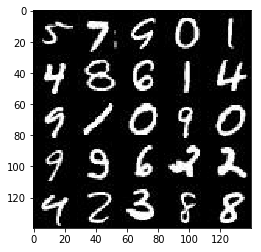

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

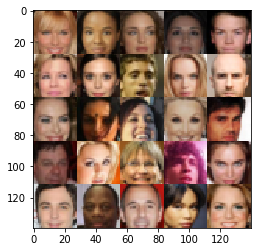

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [101]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2 # As shown in the 'DCGAN' IPython notebook

        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits

# n_units = 128 # As shown in the 'Intro-to-GANs' IPython notebook
#         # Add hidden layer
#         h1 = tf.layers.dense(images, n_units, activation=None)
#         # Add leaky ReLu
#         h1 = tf.maximum(alpha * h1, h1)
        
#         logits = tf.layers.dense(h1, 1, activation=None)
#         out = tf.sigmoid(logits)
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [102]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    if is_train == True:
        reuse = False
    else:
        reuse = True
    
    with tf.variable_scope('generator', reuse=reuse):
        alpha = 0.2
        # First FC layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape to start CNN stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [103]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                               labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                               labels=tf.ones_like(d_model_fake)))
    
    # NB: g_loss is driven entirely by how well the discriminator's logits
    # from fake data aligns to all label 1s. Antagonistically, the d_loss is driven
    # by the ability of the discriminator to maximize alignment of real data
    # to label 1s and fake data to label 0s. The end of the 2-player game is
    # reached as they approach Nash equilibrium, which is when the discriminator
    # simply outputs ~1/2 for both real and fake data.
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [104]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    training_variables = tf.trainable_variables()
    d_vars = [var for var in training_variables if var.name.startswith('discriminator')]
    g_vars = [var for var in training_variables if var.name.startswith('generator')]
    
    # Begin optimization
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [105]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [106]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     tf.reset_default_graph()
    
    # Define data parameters
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    out_channel_dim = image_channels
    
    # Collect tf input placeholders
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Calculate losses
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    
    # Setup optimization schema
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Prepare for training
    saver = tf.train.Saver()
    
    losses = []
    steps = 0
    print_every = 25
    show_every = 100
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2.0 # Transform range to [-1, 1]; this one line was added with outside help
                
                # Sample noise for generator
                batch_z = np.random.uniform(-1,1, size = (batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict = {input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    
                    show_generator_output(sess, 
                                          n_images, 
                                          input_z,
                                          out_channel_dim, 
                                          data_image_mode)

#         saver.save(sess, './checkpoints/generator.ckpt')
        
#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
        
    return losses      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.1282 Generator Loss: 0.0567
Epoch 1/2... Discriminator Loss: 1.9094 Generator Loss: 0.3527
Epoch 1/2... Discriminator Loss: 1.1364 Generator Loss: 2.5509
Epoch 1/2... Discriminator Loss: 0.8039 Generator Loss: 1.8356


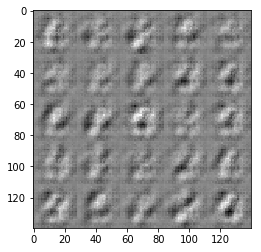

Epoch 1/2... Discriminator Loss: 0.9862 Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 1.2855 Generator Loss: 1.2891
Epoch 1/2... Discriminator Loss: 1.2804 Generator Loss: 2.4728
Epoch 1/2... Discriminator Loss: 1.1393 Generator Loss: 1.1154


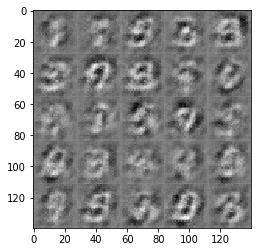

Epoch 1/2... Discriminator Loss: 1.3286 Generator Loss: 0.4415
Epoch 1/2... Discriminator Loss: 1.2408 Generator Loss: 1.2279
Epoch 1/2... Discriminator Loss: 0.9708 Generator Loss: 1.2243
Epoch 1/2... Discriminator Loss: 1.0158 Generator Loss: 1.2941


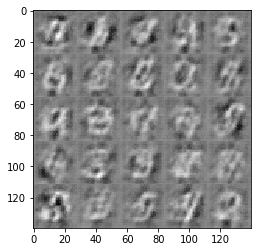

Epoch 1/2... Discriminator Loss: 1.0029 Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 1.5930 Generator Loss: 1.9553
Epoch 1/2... Discriminator Loss: 1.0994 Generator Loss: 1.6527
Epoch 1/2... Discriminator Loss: 0.8975 Generator Loss: 1.2462


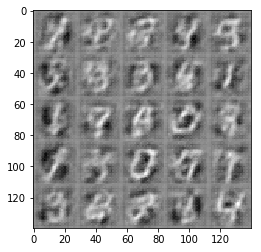

Epoch 1/2... Discriminator Loss: 1.1772 Generator Loss: 1.3153
Epoch 1/2... Discriminator Loss: 1.1816 Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 1.0017 Generator Loss: 1.1265
Epoch 1/2... Discriminator Loss: 1.0658 Generator Loss: 1.8873


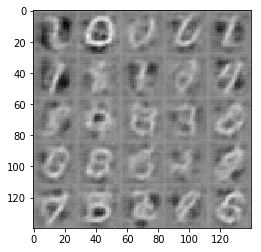

Epoch 1/2... Discriminator Loss: 1.4524 Generator Loss: 0.3692
Epoch 1/2... Discriminator Loss: 1.3092 Generator Loss: 0.4371
Epoch 1/2... Discriminator Loss: 1.1394 Generator Loss: 0.6750
Epoch 1/2... Discriminator Loss: 2.1242 Generator Loss: 0.1765


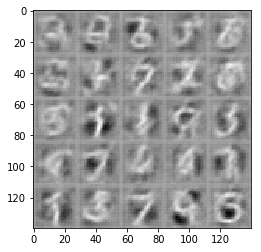

Epoch 1/2... Discriminator Loss: 1.3982 Generator Loss: 0.3658
Epoch 1/2... Discriminator Loss: 0.9269 Generator Loss: 1.2628
Epoch 1/2... Discriminator Loss: 1.2819 Generator Loss: 0.4599
Epoch 1/2... Discriminator Loss: 1.4210 Generator Loss: 0.3708


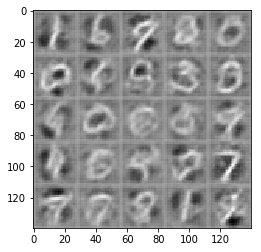

Epoch 1/2... Discriminator Loss: 1.0505 Generator Loss: 1.3289
Epoch 1/2... Discriminator Loss: 0.9172 Generator Loss: 0.7376
Epoch 1/2... Discriminator Loss: 0.9677 Generator Loss: 1.3177
Epoch 1/2... Discriminator Loss: 0.9589 Generator Loss: 0.9242


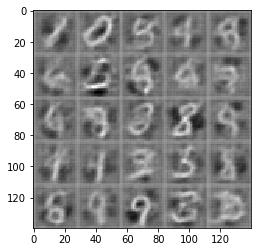

Epoch 1/2... Discriminator Loss: 1.0140 Generator Loss: 1.2357
Epoch 1/2... Discriminator Loss: 1.0394 Generator Loss: 1.1858
Epoch 1/2... Discriminator Loss: 0.9663 Generator Loss: 1.6389
Epoch 1/2... Discriminator Loss: 0.8996 Generator Loss: 0.9754


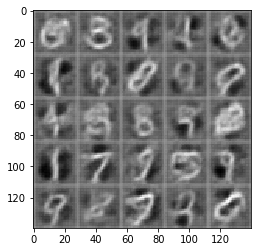

Epoch 1/2... Discriminator Loss: 0.9317 Generator Loss: 1.5088
Epoch 1/2... Discriminator Loss: 1.0993 Generator Loss: 0.5922
Epoch 1/2... Discriminator Loss: 0.8892 Generator Loss: 1.6259
Epoch 1/2... Discriminator Loss: 1.4670 Generator Loss: 0.3613


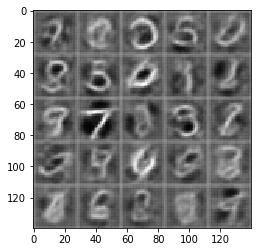

Epoch 1/2... Discriminator Loss: 1.1415 Generator Loss: 0.5302
Epoch 1/2... Discriminator Loss: 1.0964 Generator Loss: 0.7816
Epoch 1/2... Discriminator Loss: 0.9259 Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.1593 Generator Loss: 0.6666


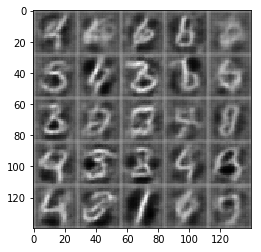

Epoch 1/2... Discriminator Loss: 0.6205 Generator Loss: 1.4751
Epoch 1/2... Discriminator Loss: 0.8799 Generator Loss: 0.7735
Epoch 1/2... Discriminator Loss: 1.0810 Generator Loss: 1.5316
Epoch 1/2... Discriminator Loss: 0.8842 Generator Loss: 1.0396


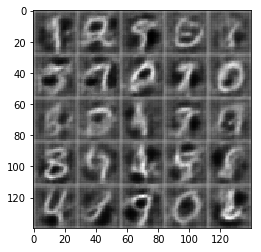

Epoch 1/2... Discriminator Loss: 0.8683 Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 1.2033 Generator Loss: 1.8447
Epoch 1/2... Discriminator Loss: 0.7708 Generator Loss: 1.6610
Epoch 1/2... Discriminator Loss: 0.8945 Generator Loss: 0.7307


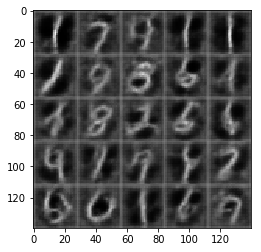

Epoch 1/2... Discriminator Loss: 0.8533 Generator Loss: 0.7161
Epoch 1/2... Discriminator Loss: 0.6540 Generator Loss: 1.0036
Epoch 1/2... Discriminator Loss: 0.7411 Generator Loss: 0.9748
Epoch 1/2... Discriminator Loss: 0.8936 Generator Loss: 0.8183


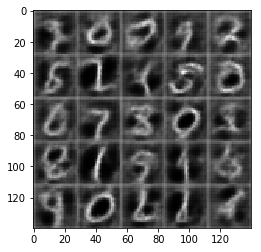

Epoch 1/2... Discriminator Loss: 0.9985 Generator Loss: 0.7028
Epoch 1/2... Discriminator Loss: 0.9632 Generator Loss: 0.6297
Epoch 1/2... Discriminator Loss: 0.6941 Generator Loss: 1.0693
Epoch 1/2... Discriminator Loss: 0.7516 Generator Loss: 0.8773


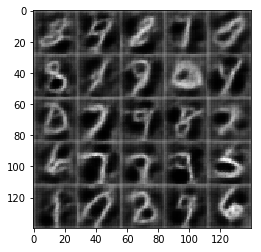

Epoch 1/2... Discriminator Loss: 0.8916 Generator Loss: 0.6840
Epoch 1/2... Discriminator Loss: 0.5750 Generator Loss: 1.1696
Epoch 1/2... Discriminator Loss: 0.4933 Generator Loss: 1.3761
Epoch 1/2... Discriminator Loss: 0.7533 Generator Loss: 0.9667


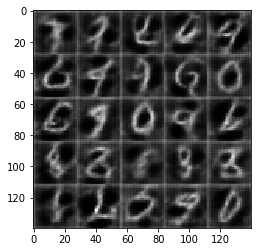

Epoch 1/2... Discriminator Loss: 0.9466 Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 1.0117 Generator Loss: 0.6182
Epoch 1/2... Discriminator Loss: 2.9603 Generator Loss: 0.0818
Epoch 1/2... Discriminator Loss: 0.3833 Generator Loss: 1.8981


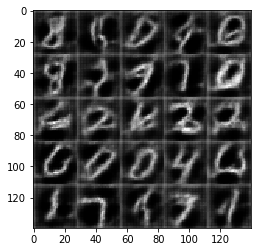

Epoch 1/2... Discriminator Loss: 0.6596 Generator Loss: 1.1271
Epoch 1/2... Discriminator Loss: 0.6217 Generator Loss: 1.0833
Epoch 1/2... Discriminator Loss: 1.4723 Generator Loss: 0.3324
Epoch 1/2... Discriminator Loss: 0.7552 Generator Loss: 0.9573


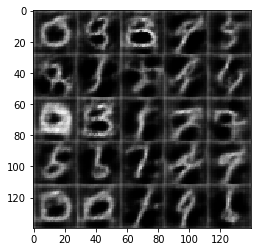

Epoch 1/2... Discriminator Loss: 0.6733 Generator Loss: 0.9455
Epoch 1/2... Discriminator Loss: 0.5453 Generator Loss: 1.4912
Epoch 1/2... Discriminator Loss: 1.0017 Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 1.1628 Generator Loss: 0.4901


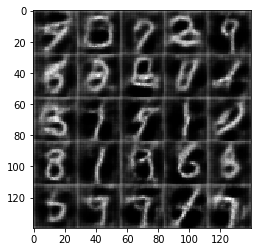

Epoch 2/2... Discriminator Loss: 0.4846 Generator Loss: 1.2696
Epoch 2/2... Discriminator Loss: 0.6978 Generator Loss: 1.6694
Epoch 2/2... Discriminator Loss: 0.5881 Generator Loss: 1.1556
Epoch 2/2... Discriminator Loss: 0.5593 Generator Loss: 1.1159


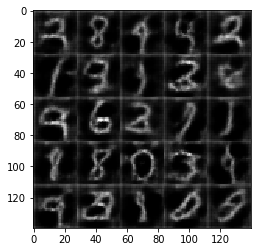

Epoch 2/2... Discriminator Loss: 1.4238 Generator Loss: 3.1680
Epoch 2/2... Discriminator Loss: 1.4391 Generator Loss: 0.3787
Epoch 2/2... Discriminator Loss: 1.9734 Generator Loss: 0.2120
Epoch 2/2... Discriminator Loss: 0.7152 Generator Loss: 0.8997


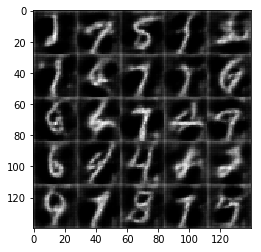

Epoch 2/2... Discriminator Loss: 0.7060 Generator Loss: 0.9928
Epoch 2/2... Discriminator Loss: 0.5926 Generator Loss: 1.9973
Epoch 2/2... Discriminator Loss: 0.3970 Generator Loss: 2.1915
Epoch 2/2... Discriminator Loss: 0.7524 Generator Loss: 0.9040


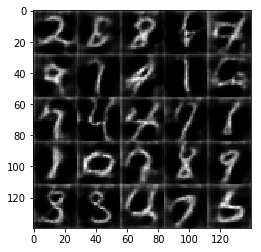

Epoch 2/2... Discriminator Loss: 1.0393 Generator Loss: 0.5878
Epoch 2/2... Discriminator Loss: 0.7501 Generator Loss: 3.3919
Epoch 2/2... Discriminator Loss: 0.5124 Generator Loss: 1.2043
Epoch 2/2... Discriminator Loss: 0.9279 Generator Loss: 0.6920


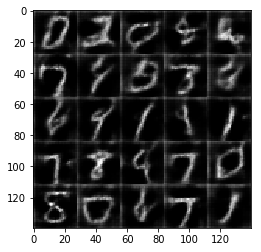

Epoch 2/2... Discriminator Loss: 1.9048 Generator Loss: 0.2329
Epoch 2/2... Discriminator Loss: 0.5307 Generator Loss: 1.3576
Epoch 2/2... Discriminator Loss: 0.6869 Generator Loss: 0.8960
Epoch 2/2... Discriminator Loss: 0.7247 Generator Loss: 0.9118


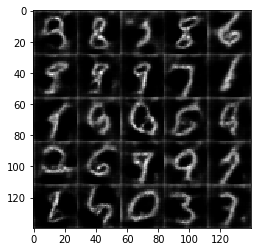

Epoch 2/2... Discriminator Loss: 0.5105 Generator Loss: 1.6194
Epoch 2/2... Discriminator Loss: 0.3775 Generator Loss: 1.5221
Epoch 2/2... Discriminator Loss: 1.5192 Generator Loss: 0.4621
Epoch 2/2... Discriminator Loss: 0.7888 Generator Loss: 0.8582


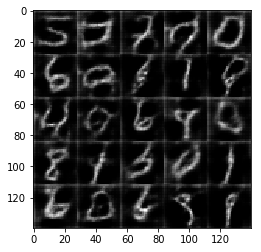

Epoch 2/2... Discriminator Loss: 0.7817 Generator Loss: 2.0438
Epoch 2/2... Discriminator Loss: 1.1749 Generator Loss: 0.4602
Epoch 2/2... Discriminator Loss: 0.9275 Generator Loss: 0.7072
Epoch 2/2... Discriminator Loss: 0.4305 Generator Loss: 1.8881


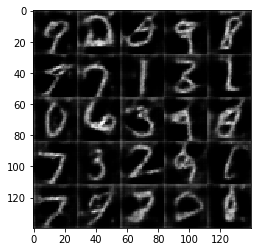

Epoch 2/2... Discriminator Loss: 0.4640 Generator Loss: 1.3372
Epoch 2/2... Discriminator Loss: 0.8889 Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 0.6265 Generator Loss: 1.0125
Epoch 2/2... Discriminator Loss: 1.3854 Generator Loss: 4.2868


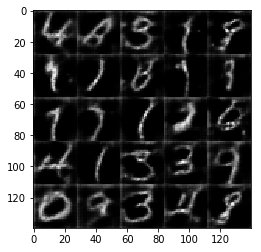

Epoch 2/2... Discriminator Loss: 1.0943 Generator Loss: 0.5324
Epoch 2/2... Discriminator Loss: 0.7334 Generator Loss: 0.8044
Epoch 2/2... Discriminator Loss: 0.4915 Generator Loss: 1.2574
Epoch 2/2... Discriminator Loss: 0.3078 Generator Loss: 1.8756


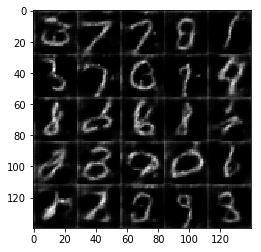

Epoch 2/2... Discriminator Loss: 0.7159 Generator Loss: 1.0452
Epoch 2/2... Discriminator Loss: 0.4035 Generator Loss: 1.4151
Epoch 2/2... Discriminator Loss: 0.6637 Generator Loss: 0.9450
Epoch 2/2... Discriminator Loss: 0.9962 Generator Loss: 0.6689


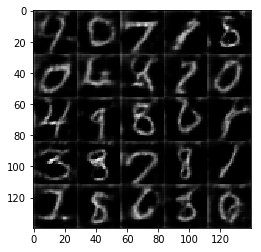

Epoch 2/2... Discriminator Loss: 0.6038 Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 0.2419 Generator Loss: 2.1499
Epoch 2/2... Discriminator Loss: 1.0077 Generator Loss: 0.6897
Epoch 2/2... Discriminator Loss: 0.2913 Generator Loss: 1.7239


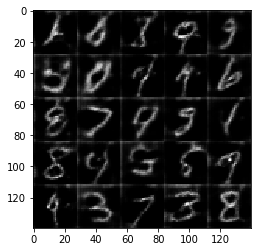

Epoch 2/2... Discriminator Loss: 1.7725 Generator Loss: 0.3672
Epoch 2/2... Discriminator Loss: 0.8628 Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 0.6489 Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 0.5409 Generator Loss: 1.1472


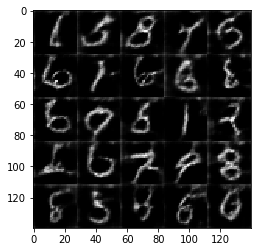

Epoch 2/2... Discriminator Loss: 2.6581 Generator Loss: 0.1183
Epoch 2/2... Discriminator Loss: 0.5514 Generator Loss: 2.6834
Epoch 2/2... Discriminator Loss: 0.2566 Generator Loss: 1.7787
Epoch 2/2... Discriminator Loss: 2.1094 Generator Loss: 0.1860


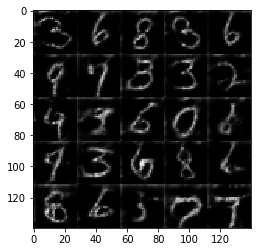

Epoch 2/2... Discriminator Loss: 0.4493 Generator Loss: 1.4466
Epoch 2/2... Discriminator Loss: 0.4769 Generator Loss: 1.6266
Epoch 2/2... Discriminator Loss: 0.4571 Generator Loss: 1.2823
Epoch 2/2... Discriminator Loss: 0.9466 Generator Loss: 0.6899


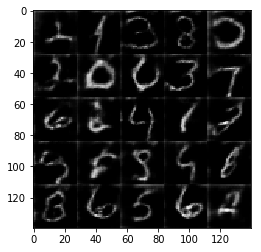

Epoch 2/2... Discriminator Loss: 0.6063 Generator Loss: 1.0925
Epoch 2/2... Discriminator Loss: 0.5372 Generator Loss: 1.2078
Epoch 2/2... Discriminator Loss: 0.4687 Generator Loss: 1.3908
Epoch 2/2... Discriminator Loss: 0.2610 Generator Loss: 2.1248


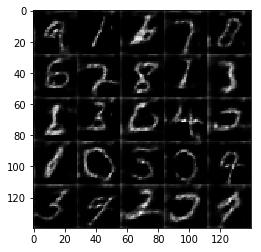

Epoch 2/2... Discriminator Loss: 0.3558 Generator Loss: 1.5481
Epoch 2/2... Discriminator Loss: 0.2783 Generator Loss: 1.7106
Epoch 2/2... Discriminator Loss: 0.3850 Generator Loss: 2.0203
Epoch 2/2... Discriminator Loss: 0.8578 Generator Loss: 0.7459


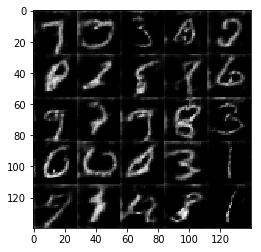

Epoch 2/2... Discriminator Loss: 0.5330 Generator Loss: 3.7898
Epoch 2/2... Discriminator Loss: 0.9418 Generator Loss: 1.0121
Epoch 2/2... Discriminator Loss: 1.8831 Generator Loss: 0.3592
Epoch 2/2... Discriminator Loss: 0.5679 Generator Loss: 1.1279


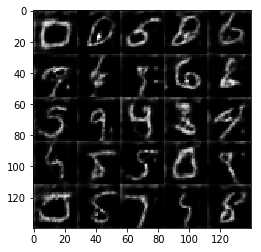

Epoch 2/2... Discriminator Loss: 0.2009 Generator Loss: 2.3561
Epoch 2/2... Discriminator Loss: 1.5422 Generator Loss: 0.4263
Epoch 2/2... Discriminator Loss: 0.4034 Generator Loss: 1.4952
Epoch 2/2... Discriminator Loss: 0.2393 Generator Loss: 2.0401


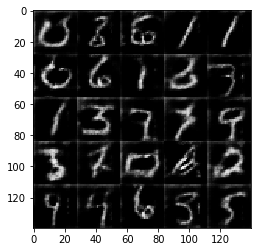

Epoch 2/2... Discriminator Loss: 0.9652 Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 0.9954 Generator Loss: 0.6875


In [107]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.3696 Generator Loss: 0.0528
Epoch 1/1... Discriminator Loss: 1.9306 Generator Loss: 0.1927
Epoch 1/1... Discriminator Loss: 0.7735 Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.3409 Generator Loss: 0.5013


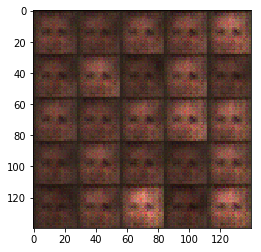

Epoch 1/1... Discriminator Loss: 0.9673 Generator Loss: 1.4443
Epoch 1/1... Discriminator Loss: 1.3205 Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 1.5482 Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.4680 Generator Loss: 0.3996


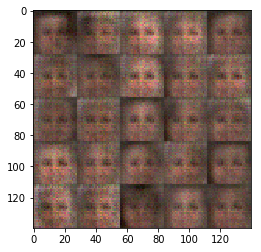

Epoch 1/1... Discriminator Loss: 1.2767 Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 1.6683 Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 1.3609 Generator Loss: 0.4479
Epoch 1/1... Discriminator Loss: 1.1772 Generator Loss: 1.1947


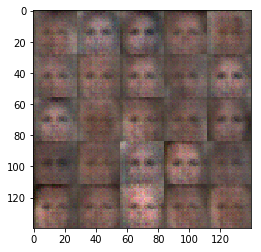

Epoch 1/1... Discriminator Loss: 1.2366 Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 1.8324 Generator Loss: 0.2477
Epoch 1/1... Discriminator Loss: 1.3786 Generator Loss: 0.4026
Epoch 1/1... Discriminator Loss: 1.1186 Generator Loss: 0.9231


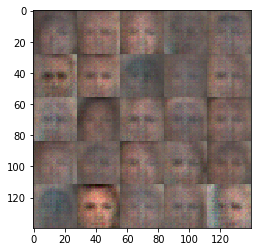

Epoch 1/1... Discriminator Loss: 1.3798 Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.4678 Generator Loss: 0.3939
Epoch 1/1... Discriminator Loss: 1.3561 Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.2937 Generator Loss: 0.6468


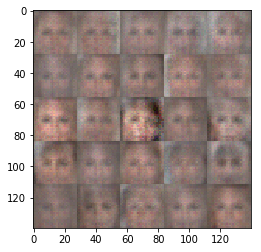

Epoch 1/1... Discriminator Loss: 1.1901 Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.4358 Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.3410 Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.3486 Generator Loss: 0.6271


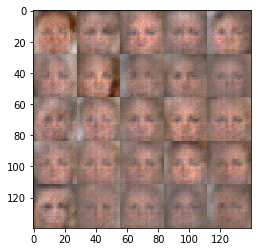

Epoch 1/1... Discriminator Loss: 1.4829 Generator Loss: 0.4214
Epoch 1/1... Discriminator Loss: 1.3564 Generator Loss: 1.0360
Epoch 1/1... Discriminator Loss: 1.4510 Generator Loss: 0.4410
Epoch 1/1... Discriminator Loss: 1.2517 Generator Loss: 0.7248


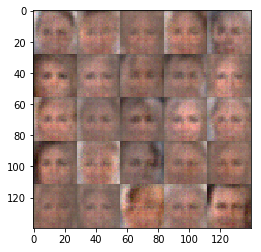

Epoch 1/1... Discriminator Loss: 1.2597 Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.1473 Generator Loss: 1.3149
Epoch 1/1... Discriminator Loss: 1.1635 Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.1903 Generator Loss: 0.9533


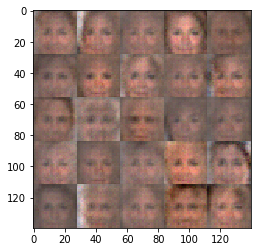

Epoch 1/1... Discriminator Loss: 1.4485 Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 1.2831 Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.1887 Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.2199 Generator Loss: 0.7081


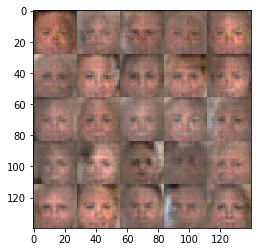

Epoch 1/1... Discriminator Loss: 1.2893 Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.2465 Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.2589 Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.2152 Generator Loss: 0.9687


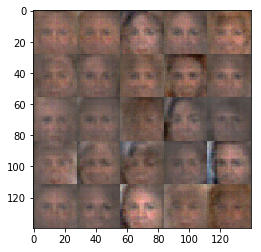

Epoch 1/1... Discriminator Loss: 1.2541 Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.3910 Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.4755 Generator Loss: 1.2732
Epoch 1/1... Discriminator Loss: 1.4465 Generator Loss: 0.4100


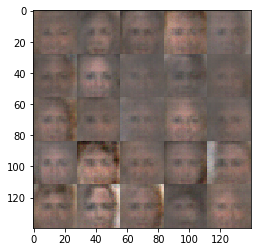

Epoch 1/1... Discriminator Loss: 1.2871 Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.5577 Generator Loss: 0.3306
Epoch 1/1... Discriminator Loss: 1.5611 Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 1.3397 Generator Loss: 1.2179


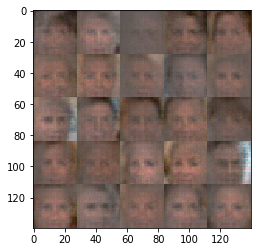

Epoch 1/1... Discriminator Loss: 1.5826 Generator Loss: 0.2958
Epoch 1/1... Discriminator Loss: 1.4217 Generator Loss: 1.5475
Epoch 1/1... Discriminator Loss: 1.5539 Generator Loss: 0.3212
Epoch 1/1... Discriminator Loss: 1.2052 Generator Loss: 0.8274


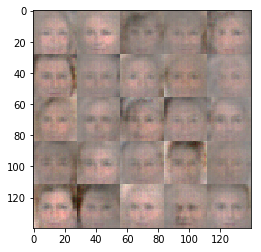

Epoch 1/1... Discriminator Loss: 1.0144 Generator Loss: 1.8349
Epoch 1/1... Discriminator Loss: 1.0140 Generator Loss: 0.7681


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.